Best Params for XGBRegressor: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200}
CV RMSE for XGBRegressor (log scale): 0.4231
Training Time: 4.08 sec

Model Evaluation on Test Set (back-transformed to sale price scale):
Training RMSE: 716,082.66 | Test RMSE: 1,013,728.38
Training R^2: 0.87 | Test R^2: 0.68


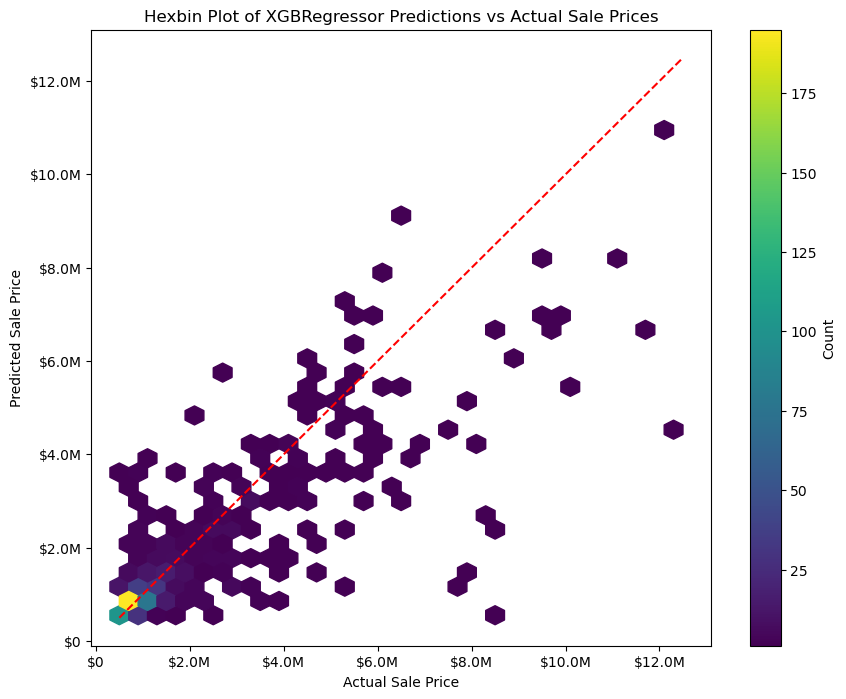

In [2]:
# -----------------------------
# 1. Import Libraries & Load Data
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import xgboost as xgb
import matplotlib.ticker as ticker

# Adjust file path as needed
file_path = "../data/commericalnj.csv"
df = pd.read_csv(file_path, low_memory=False)

# -----------------------------
# 2. Data Cleaning & Time Feature Extraction
# -----------------------------
# Convert 'Sale Date' to datetime and extract time features.
df.loc[:, 'Sale Date'] = pd.to_datetime(df.loc[:, 'Sale Date'], errors='coerce')
df.loc[:, 'Sale Year'] = df.loc[:, 'Sale Date'].apply(lambda x: x.year if pd.notnull(x) else np.nan)
df.loc[:, 'Sale Month'] = df.loc[:, 'Sale Date'].apply(lambda x: x.month if pd.notnull(x) else np.nan)

# Create cyclic features for Sale Month to capture seasonality.
df.loc[:, 'Sale Month Sine'] = np.sin(2 * np.pi * df.loc[:, 'Sale Month'] / 12)
df.loc[:, 'Sale Month Cosine'] = np.cos(2 * np.pi * df.loc[:, 'Sale Month'] / 12)

# Convert key numeric columns to numbers.
numeric_cols = ['Sq. Ft.', 'Yr. Built', 'Acreage', 'Latitude', 'Longitude', 'Sale Price',
                'Total Assmnt', 'Taxes 1']
for col in numeric_cols:
    df.loc[:, col] = pd.to_numeric(df.loc[:, col], errors='coerce')

# -----------------------------
# 3. Remove Irregular Transactions & Extreme Outliers
# -----------------------------
# First, filter out transactions with a sale price below $500,000.
threshold_min = 500000
df_market = df[df['Sale Price'] >= threshold_min].copy()

# Now, remove extreme outliers. For example, remove properties above the 95th percentile.
upper_threshold = df_market['Sale Price'].quantile(0.95)
df_market = df_market[df_market['Sale Price'] <= upper_threshold].copy()

# -----------------------------
# 4. Feature Engineering on the Cleaned DataFrame
# -----------------------------
# Define the key columns to use. Include additional features.
selected_cols = ['Sq. Ft.', 'Yr. Built', 'Acreage', 'Sale Year', 'Sale Month Sine', 'Sale Month Cosine',
                 'Latitude', 'Longitude', 'Sale Price', 'Municipality', 'Property Class', 'Type/Use',
                 'Total Assmnt', 'Taxes 1', 'Neigh']
df_market = df_market.dropna(subset=selected_cols).copy()

# Create a derived feature: Building Age (current year minus Yr. Built)
current_year = pd.Timestamp.today().year
df_market.loc[:, 'Building Age'] = current_year - df_market.loc[:, 'Yr. Built']

# Create the target variable: apply a log transformation on Sale Price to reduce skewness.
df_market.loc[:, 'Log Sale Price'] = np.log1p(df_market.loc[:, 'Sale Price'])

# -----------------------------
# 5. Define Feature Sets and Split Data
# -----------------------------
# Numerical features (continuous values)
numerical_features = ['Sq. Ft.', 'Acreage', 'Building Age', 'Sale Year', 'Sale Month Sine', 'Sale Month Cosine',
                      'Latitude', 'Longitude', 'Total Assmnt', 'Taxes 1']

# Categorical features (non-numeric values)
categorical_features = ['Municipality', 'Property Class', 'Type/Use', 'Neigh']

# Final feature list and target variable
features = numerical_features + categorical_features
target = 'Log Sale Price'

X = df_market.loc[:, features]
y = df_market.loc[:, target]

# Split the data into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 6. Create a Preprocessing Pipeline
# -----------------------------
# For numerical features, apply StandardScaler; for categorical features, apply OneHotEncoder.
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# -----------------------------
# 7. Build the Model Pipeline with XGBoost
# -----------------------------
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# -----------------------------
# 8. Hyperparameter Tuning with GridSearchCV
# -----------------------------
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf,
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

best_params = grid_search.best_params_
cv_rmse = -grid_search.best_score_  # RMSE on the log-transformed target
best_estimator = grid_search.best_estimator_

print("Best Params for XGBRegressor:", best_params)
print(f"CV RMSE for XGBRegressor (log scale): {cv_rmse:.4f}")
print(f"Training Time: {elapsed_time:.2f} sec")

# -----------------------------
# 9. Model Evaluation on Test Set (Back-Transformed)
# -----------------------------
# Predict on the training and test sets (predictions are in log scale).
y_train_pred_log = best_estimator.predict(X_train)
y_test_pred_log = best_estimator.predict(X_test)

# Convert predictions back to the original sale price scale.
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print("\nModel Evaluation on Test Set (back-transformed to sale price scale):")
print(f"Training RMSE: {train_rmse:,.2f} | Test RMSE: {test_rmse:,.2f}")
print(f"Training R^2: {train_r2:.2f} | Test R^2: {test_r2:.2f}")

# -----------------------------
# 10. Plot Predicted vs. Actual Sale Prices with Abbreviated Axes
# -----------------------------
plt.figure(figsize=(10, 8))
plt.hexbin(y_test_actual, y_test_pred, gridsize=30, cmap='viridis', mincnt=1)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Hexbin Plot of XGBRegressor Predictions vs Actual Sale Prices")

ax = plt.gca()
def millions_formatter(x, pos):
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    else:
        return f'${x:.0f}'
formatter = ticker.FuncFormatter(millions_formatter)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
cb = plt.colorbar()
cb.set_label('Count')

plt.show()
